In [1]:
import camb
import pywigxjpf as pywig
from joblib import Parallel, delayed
import sys, argparse, multiprocessing
#from common import *
from scipy.signal import savgol_filter

In [2]:
import numpy as np
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
import os

In [3]:
nside = 2560

In [4]:
print("  Creating pywig tables...")
NSIDE_MAX = 4096
pywig.wig_table_init(3*nside, 3)
pywig.wig_temp_init(3*nside)

  Creating pywig tables...


In [11]:
L_RECONST_MAX = 100

In [6]:
def GammakSZ(l1, l2, l, Cltd) :
    pref = np.sqrt((2.0*l1+1)*(2.0*l2+1)*(2.0*l+1)/4.0/np.pi)
    wig = pywig.wig3jj(2*l1, 2*l2, 2*l, 0, 0, 0) # 2*[j1,j2,j3,m1,m2,m3]
    return pref*wig*Cltd[l2]

def getNinv(l, ls, Cltd, ClTT, Cldd) :
    Ninv = 0.0
    if l < L_RECONST_MAX+1 :
        print("Working on l =", l)
        for l1 in ls: # TODO: don't include monopole, dipole contributions?
            for l2 in ls:
                Ninv += GammakSZ(l1, l2, l, Cltd)**2 / ClTT[l1] / Cldd[l2]
        Ninv /= (2.0*l + 1.0)
    else :
        Ninv = 1.0e50 # N = 1.0e-50
    return Ninv

In [7]:
h=0.69
pars = camb.CAMBparams()
pars.set_cosmology(H0=100.0*h, ombh2=0.048*h**2, omch2=0.262*h**2, mnu=0.06, omk=0)
pars.InitPower.set_params(As=2e-9, ns=0.96, r=0)
pars.set_for_lmax(6144, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
l=np.arange(0,len(powers['total'][:,0]))
cambFactor = l*(l+1)/(2*np.pi)
CMB_camb = powers['total'][:,0]/cambFactor
CMB_camb[0]=0.0

<ipython-input-7-d860381747c2>:10: RuntimeWarning: invalid value encountered in true_divide
  CMB_camb = powers['total'][:,0]/cambFactor


In [8]:
kSZ = np.load('./kSZ_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')
overdensity = np.load('./overdensity_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')
VelocityField = np.load('./VelocityField_NS_2560_R_2968_P_2048_DV_256_Sd_945986.npy')

In [9]:
rho_map = overdensity

ksz_PS = hp.anafast(kSZ)

CMB_map = hp.sphtfunc.synfast(CMB_camb,nside=nside);
    
Obs_T_map = kSZ + CMB_map

ClTT = hp.anafast(Obs_T_map)
ClTT_filtered = np.concatenate(([1.0], savgol_filter(ClTT[1:], 51, 3)))
Cldd = hp.anafast(rho_map)
Cltd = hp.anafast(rho_map, map2=-rho_map)
ls = np.arange(ClTT.size)
    
dTlm = hp.map2alm(Obs_T_map)
dlm = hp.map2alm(rho_map)

dTlm_resc = hp.almxfl(dTlm, 1.0/ClTT)
dT_resc = hp.alm2map(dTlm_resc, nside)
dlm = -1.0*dlm # dlm_resc = hp.almxfl(dlm, 1.0) #Cltd/Cldd
d_resc = hp.alm2map(dlm, nside)

/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:433: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/home/wurdahl/miniconda3/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(


In [12]:
#figuring out scaling factor
print("Scaling factor")
#Compute noise (expensive, need to optimize?)
print("Computing noise.")
ncores = multiprocessing.cpu_count()
lsMax=np.arange(5700)
Ninv = [ getNinv(l, lsMax, Cltd, ClTT, Cldd) for l in range(L_RECONST_MAX) ]
#Ninv = Parallel(n_jobs=ncores)(delayed(getNinv)(l, ls, Cltd, ClTT, Cldd) for l in ls)
N = 1.0/np.array(Ninv)
#N = np.zeros_like(ls, dtype=np.int)
#N[:100] = 1.0
    
unnorm_veff_reconstlm = hp.map2alm(dT_resc*d_resc,lmax=L_RECONST_MAX)
veff_reconstlm = hp.almxfl(unnorm_veff_reconstlm,fl=N)
unnorm_veff_reconst_ps = hp.alm2cl(unnorm_veff_reconstlm)
unnorm_veff_reconst = hp.alm2map(unnorm_veff_reconstlm, nside)
veff_reconst = hp.alm2map(veff_reconstlm, nside)


Scaling factor
Computing noise.
Working on l = 0
Working on l = 1
Working on l = 2
Working on l = 3
Working on l = 4
Working on l = 5
Working on l = 6
Working on l = 7
Working on l = 8
Working on l = 9
Working on l = 10
Working on l = 11
Working on l = 12
Working on l = 13
Working on l = 14
Working on l = 15
Working on l = 16
Working on l = 17
Working on l = 18
Working on l = 19
Working on l = 20
Working on l = 21
Working on l = 22
Working on l = 23
Working on l = 24
Working on l = 25
Working on l = 26
Working on l = 27
Working on l = 28
Working on l = 29
Working on l = 30
Working on l = 31
Working on l = 32
Working on l = 33
Working on l = 34
Working on l = 35
Working on l = 36
Working on l = 37
Working on l = 38
Working on l = 39
Working on l = 40
Working on l = 41
Working on l = 42
Working on l = 43
Working on l = 44
Working on l = 45
Working on l = 46
Working on l = 47
Working on l = 48
Working on l = 49
Working on l = 50
Working on l = 51
Working on l = 52
Working on l = 53
Workin

In [13]:
N

array([9.80892776e-16, 9.81070522e-16, 9.81158984e-16, 9.81285118e-16,
       9.81383494e-16, 9.81507726e-16, 9.81606713e-16, 9.81724086e-16,
       9.81828568e-16, 9.81944356e-16, 9.82051489e-16, 9.82164360e-16,
       9.82270731e-16, 9.82386531e-16, 9.82491124e-16, 9.82607593e-16,
       9.82712800e-16, 9.82829853e-16, 9.82933786e-16, 9.83050865e-16,
       9.83156378e-16, 9.83270266e-16, 9.83373372e-16, 9.83486671e-16,
       9.83592148e-16, 9.83705478e-16, 9.83810001e-16, 9.83921795e-16,
       9.84027783e-16, 9.84139400e-16, 9.84241741e-16, 9.84353524e-16,
       9.84457894e-16, 9.84568232e-16, 9.84672296e-16, 9.84784859e-16,
       9.84889308e-16, 9.84999336e-16, 9.85103989e-16, 9.85214841e-16,
       9.85318613e-16, 9.85429390e-16, 9.85532633e-16, 9.85644018e-16,
       9.85748437e-16, 9.85858609e-16, 9.85963227e-16, 9.86071038e-16,
       9.86177298e-16, 9.86285465e-16, 9.86390304e-16, 9.86499394e-16,
       9.86603813e-16, 9.86711540e-16, 9.86816278e-16, 9.86924055e-16,
      

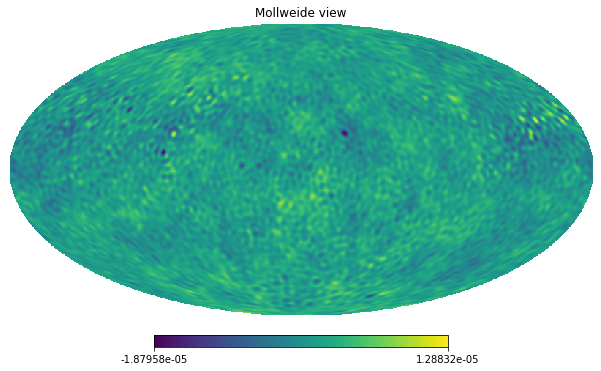

In [14]:
hp.mollview(veff_reconst)

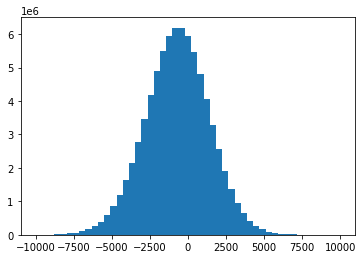

In [17]:
plt.hist(VelocityField,bins=np.linspace(-10000,10000));

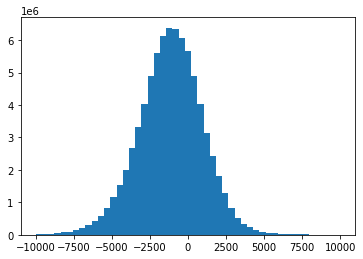

In [21]:
plt.hist(10**9*veff_reconst,bins=np.linspace(-10000,10000));

In [27]:
diff = VelocityField-(10**9*veff_reconst+400)

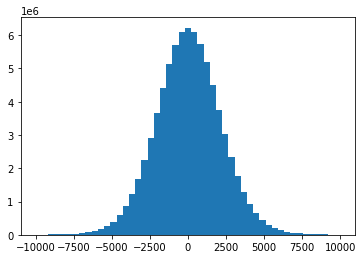

In [28]:
plt.hist(diff,bins=np.linspace(-10000,10000));

In [24]:
import numpy as np
import sklearn.mixture

mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit(VelocityField[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : -719.786416, std dev : 2100.559290


In [25]:
mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit(10**9*veff_reconst[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : -1157.810348, std dev : 2142.184955


In [29]:
mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit(diff[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : 38.023932, std dev : 2181.742155


In [33]:
velField_alm = hp.map2alm(VelocityField,lmax=L_RECONST_MAX)

In [35]:
velField_LowL = hp.alm2map(velField_alm,nside)

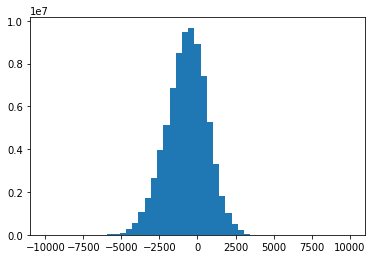

In [39]:
plt.hist(velField_LowL,bins=np.linspace(-10000,10000));

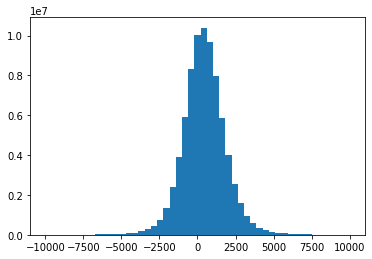

In [43]:
plt.hist(velField_LowL-10**9*veff_reconst,bins=np.linspace(-10000,10000));

In [44]:
mixture = sklearn.mixture.GaussianMixture()

# result
r = mixture.fit((velField_LowL-10**9*veff_reconst)[:, np.newaxis]) # GMM requires 2D data as of sklearn version 0.16
print("mean : %f, std dev : %f" % (r.means_[0, 0], np.sqrt(r.covariances_[0, 0])))

mean : 438.023932, std dev : 1464.922968


## Cl resclaing

In [45]:
velField_ps = hp.anafast(VelocityField)
velRecon_ps = hp.anafast(unnorm_veff_reconst)

In [46]:
unnorm_veff_reconstlm = hp.map2alm(dT_resc*d_resc,lmax=ClTT.size)

In [53]:
veff_reconstlm_ClRescale = hp.almxfl(unnorm_veff_reconstlm,fl=np.sqrt(velField_ps/velRecon_ps))

In [54]:
veff_recon_ClRescale = hp.alm2map(veff_reconstlm_ClRescale,nside)

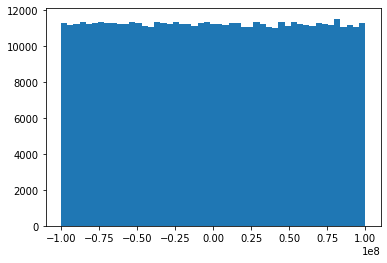

In [60]:
plt.hist(veff_recon_ClRescale,bins=np.linspace(-100000000,100000000));

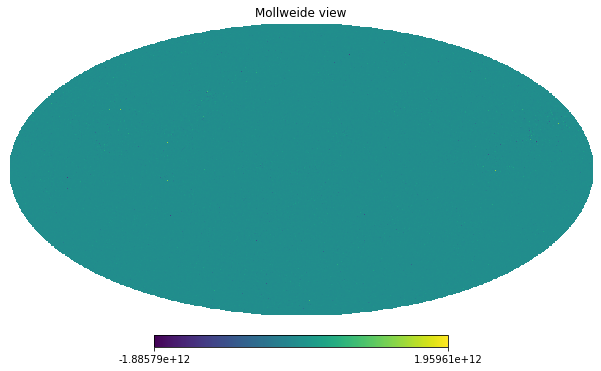

In [59]:
hp.mollview(veff_recon_ClRescale)